# Implement two Recommender systems: 

## A. Popularity-based: by number of the user who watched the movie
## B. Similiarity-based: by rating from people with similiar movie tastes

# Error Analysis
We are going to explore effectiveness by different methods like root mean square distance


### Import Libraries

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# for checking results sklearn metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

### Read data

In [53]:
movies = pd.read_csv("https://github.com/tiagofassoni/useful-datasets/raw/main/ml-latest-small/movies.csv").drop_duplicates()
ratings = pd.read_csv("https://github.com/tiagofassoni/useful-datasets/raw/main/ml-latest-small/ratings.csv").drop_duplicates()

## A. Popularity based recommendation
we group the ratings by movie Id and sort them in descending order to get top 5 popular movies e.g. the movies most of the users rated.

In [54]:
popular_movies = ratings.groupby('movieId').rating.size().sort_values(ascending = False).reset_index().head(10)
popular_movies

,movieId,rating
0,356,329
1,318,317
2,296,307
3,593,279
4,2571,278
5,260,251
6,480,238
7,110,237
8,589,224
9,527,220


In [55]:
# name, rating and genre of top 10 popular movies

popular_movies.merge(movies, on = 'movieId', how = 'left')

#there is another way to do this 
#pop = movies[movies.movieId.isin(popular_movies.index)]

,movieId,rating,title,genres
0,356,329,Forrest Gump (1994),Comedy|Drama|Romance|War
1,318,317,"Shawshank Redemption, The (1994)",Crime|Drama
2,296,307,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller
3,593,279,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller
4,2571,278,"Matrix, The (1999)",Action|Sci-Fi|Thriller
5,260,251,Star Wars: Episode IV - A New Hope (1977),Action|Adventure|Sci-Fi
6,480,238,Jurassic Park (1993),Action|Adventure|Sci-Fi|Thriller
7,110,237,Braveheart (1995),Action|Drama|War
8,589,224,Terminator 2: Judgment Day (1991),Action|Sci-Fi
9,527,220,Schindler's List (1993),Drama|War


# B. Similarity based reccomendation: cosine similarity

### 1. Building a Recommender function from scratch (Iteration 1)
### 2. Make a train-test split of the data and do the same (Iteration 2)

## 1. Building a Recommender function from scratch (Iteration 1)

## Create the similarity matrix



### 1.Merge ratings & movies 


In [56]:
from sklearn.metrics.pairwise import cosine_similarity

data = ratings.merge(movies, on="movieId", how="left")
data.head(4)

,userId,movieId,rating,timestamp,title,genres
0,1,1,4.0,964982703,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,1,3,4.0,964981247,Grumpier Old Men (1995),Comedy|Romance
2,1,6,4.0,964982224,Heat (1995),Action|Crime|Thriller
3,1,47,5.0,964983815,Seven (a.k.a. Se7en) (1995),Mystery|Thriller


### 2.1. Create the big users-movies table.

We are just reshaping (pivoting) the data, so that we have users as rows and movies as columns. We need the data to be in this shape to compute similarities between users in the next step.

In [57]:
movie_user = data.pivot_table(index='userId',columns='title',values='rating')
movie_user.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 2.2. Replace NaNs with zeroes

We know zeroes will have an impact on the predicted ratings, and we don't want it! It is just a provisional solution so that we can compute similarities.

In [58]:
movie_user.fillna(0, inplace=True)
movie_user.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 3. Compute pairwise cosine similarities

In [59]:
user_similarities = pd.DataFrame(cosine_similarity(movie_user),
                                 columns=movie_user.index, 
                                 index=movie_user.index)
user_similarities.head()

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.027283,0.059720,0.194395,0.129080,0.128152,0.158744,0.136968,0.064263,0.016875,...,0.080554,0.164455,0.221486,0.070669,0.153625,0.164191,0.269389,0.291097,0.093572,0.145321
2,0.027283,1.000000,0.000000,0.003726,0.016614,0.025333,0.027585,0.027257,0.000000,0.067445,...,0.202671,0.016866,0.011997,0.000000,0.000000,0.028429,0.012948,0.046211,0.027565,0.102427
3,0.059720,0.000000,1.000000,0.002251,0.005020,0.003936,0.000000,0.004941,0.000000,0.000000,...,0.005048,0.004892,0.024992,0.000000,0.010694,0.012993,0.019247,0.021128,0.000000,0.032119
4,0.194395,0.003726,0.002251,1.000000,0.128659,0.088491,0.115120,0.062969,0.011361,0.031163,...,0.085938,0.128273,0.307973,0.052985,0.084584,0.200395,0.131746,0.149858,0.032198,0.107683
5,0.129080,0.016614,0.005020,0.128659,1.000000,0.300349,0.108342,0.429075,0.000000,0.030611,...,0.068048,0.418747,0.110148,0.258773,0.148758,0.106435,0.152866,0.135535,0.261232,0.060792


## Building the function step by step:

Let's focus on one random user (user `80`) and compute the recommendations only for this user, as an example. Then, we will build a function that can compute recommendations for any users. We will follow these steps:

1. Compute the weights.

2. Find movies user `80` has not rated.

3. Compute the ratings user `80` would give to those unrated movies.

4. Find the top 5 movies from the rating predictions.

In [60]:
user_id = 80

### 1. Compute the weights

Here we will exclude user 80 using `query`.

In [61]:
# compute the weights for one user
weights = user_similarities.query("userId!=@user_id")[user_id] / sum(user_similarities.query("userId!=@user_id")[user_id])
weights.head(2)

userId
1    0.001162
2    0.002516
Name: 80, dtype: float64

### 2. Find movies user `80` has not rated.

We will again exclude our user, since we don't want to include them on the weights.

In [62]:
# select movies that the inputed user has not seen
unseen_movies = movie_user.loc[movie_user.index!=user_id, movie_user.loc[user_id,:]==0]
unseen_movies.head(2)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 3. Compute the ratings user `80` would give to those unrated movies.

In [63]:
# multiply the unseen movies and the weights
weighted_averages = unseen_movies.T.dot(weights)
weighted_averages.head()

# alternative method:
# weighted_averages = unseen_movies.multiply(weights, axis=0).sum()

title
'71 (2014)                                 0.019124
'Hellboy': The Seeds of Creation (2004)    0.015911
'Round Midnight (1986)                     0.016997
'Salem's Lot (2004)                        0.004787
'Til There Was You (1997)                  0.005524
dtype: float64

### 4. Find the top 5 movies from the rating predictions

In [64]:
weighted_averages.sort_values(ascending=False).head(5)

title
Forrest Gump (1994)                                          2.795532
Pulp Fiction (1994)                                          2.688947
Star Wars: Episode IV - A New Hope (1977)                    2.355558
Lord of the Rings: The Fellowship of the Ring, The (2001)    2.274043
Lord of the Rings: The Return of the King, The (2003)        2.223876
dtype: float64

## Define the recommender function

All the previous steps together

In [65]:
def rec_iter1(user_id, n):
    '''
    similarity matrix: has to be previously computed
    user_id: the user for which to provide recommendations
    n: the number of recommendations to provide
    '''
    
    # compute the weights for the inputed user
    weights = user_similarities.query("userId!=@user_id")[user_id] / sum(user_similarities.query("userId!=@user_id")[user_id])
    
    # select movies that the inputed user has not seen
    unseen_movies = movie_user.loc[movie_user.index!=user_id, movie_user.loc[user_id,:]==0]
    
    # multiply the unseen movies and the weights
    weighted_averages = unseen_movies.T.dot(weights)
    
    # get the top n movies
    recommendations = weighted_averages.sort_values(ascending=False).head(n).index.tolist()
    
    return recommendations

### Give `5` recommendations for user `1`

In [66]:
rec_iter1(user_id = 6, 
          n = 5)

['Toy Story (1995)',
 'Star Wars: Episode IV - A New Hope (1977)',
 'Mission: Impossible (1996)',
 'Matrix, The (1999)',
 'Star Wars: Episode V - The Empire Strikes Back (1980)']


# 2. Make a train-test split of the data and do the same (Iteration 2)
 We have to be sure that many non zero values should be found in both in train and test. To make sure this happens first find the non zero values in move_user

In [67]:
# all the ratings other than 0 in movie user table
np.nonzero(np.array(movie_user))

(array([  0,   0,   0, ..., 609, 609, 609], dtype=int64),
 array([  48,   66,  202, ..., 9712, 9715, 9716], dtype=int64))

In [68]:
#create dataframe containing the positions with nonzero values
ratings_pos = pd.DataFrame(np.nonzero(np.array(movie_user))).T # we have to transpose it also

In [69]:
ratings_pos.head()

,0,1
0,0,48
1,0,66
2,0,202
3,0,245
4,0,325


In [70]:
# split with train and test
from sklearn.model_selection import train_test_split

train_pos, test_pos = train_test_split(ratings_pos, random_state=42, test_size=.2)

In [71]:
# create empty sparse dataframe, with same shape as movies_user
train = np.zeros(movie_user.shape)

In [72]:
# fill the set with the movie ratings based on the train positions

for pos in train_pos.values:
    index = pos[0]
    col = pos[1]
    train[index, col] = movie_user.iloc[index, col]
train = pd.DataFrame(train, index = movie_user.index, columns= movie_user.columns).apply(pd.to_numeric, downcast='integer')

In [73]:
test = np.zeros(movie_user.shape)
for pos in test_pos.values:
    index = pos[0]
    col = pos[1]
    test[index, col] = movie_user.iloc[index, col]

In [74]:
test = pd.DataFrame(test, columns=movie_user.columns, index=movie_user.index).apply(pd.to_numeric, downcast='integer')

In [75]:
train.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,4.0,0
2,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0
3,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0
4,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0
5,0,0,0.0,0,0,0.0,0.0,0,0.0,0.0,...,0.0,0.0,0.0,0,0,0.0,0.0,0.0,0.0,0


In [76]:
test

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...,Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,
1,0,0,0,0,0,0,0,0,0.0,0,...,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0
2,0,0,0,0,0,0,0,0,0.0,0,...,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0
3,0,0,0,0,0,0,0,0,0.0,0,...,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0
4,0,0,0,0,0,0,0,0,0.0,0,...,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0
5,0,0,0,0,0,0,0,0,0.0,0,...,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0,0,0,0,0,0,0,0,0.0,0,...,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0
607,0,0,0,0,0,0,0,0,0.0,0,...,0,0,0.0,0,0,0.0,0.0,0.0,0.0,0
608,0,0,0,0,0,0,0,0,0.0,0,...,0,0,0.0,0,0,4.5,0.0,0.0,0.0,0


In [77]:
# First create cosine similarity based on train dataset
train_similarity = pd.DataFrame(cosine_similarity(train), columns=movie_user.index, index=movie_user.index)

In [78]:
train_similarity

userId,1,2,3,4,5,6,7,8,9,10,...,601,602,603,604,605,606,607,608,609,610
userId,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.031626,0.035531,0.125098,0.107865,0.123280,0.152126,0.087723,0.044993,0.017701,...,0.064287,0.082829,0.194839,0.062961,0.155198,0.123113,0.254713,0.218869,0.084478,0.121576
2,0.031626,1.000000,0.000000,0.004387,0.018694,0.017234,0.033263,0.032458,0.000000,0.079585,...,0.197817,0.000000,0.007633,0.000000,0.000000,0.028793,0.014946,0.038435,0.031850,0.090568
3,0.035531,0.000000,1.000000,0.002882,0.006141,0.003057,0.000000,0.006397,0.000000,0.000000,...,0.002957,0.000000,0.017489,0.000000,0.000000,0.007067,0.006481,0.007992,0.000000,0.031140
4,0.125098,0.004387,0.002882,1.000000,0.101251,0.071909,0.086717,0.041120,0.000000,0.021265,...,0.042861,0.081587,0.255416,0.046705,0.059801,0.173615,0.114842,0.119231,0.039472,0.075653
5,0.107865,0.018694,0.006141,0.101251,1.000000,0.251807,0.082998,0.314250,0.000000,0.037557,...,0.056112,0.315137,0.103713,0.263564,0.119079,0.075165,0.137687,0.122678,0.256967,0.050392
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,0.123113,0.028793,0.007067,0.173615,0.075165,0.089347,0.146544,0.042441,0.059436,0.063117,...,0.118904,0.088835,0.234581,0.054585,0.130681,1.000000,0.131753,0.201126,0.047658,0.163340
607,0.254713,0.014946,0.006481,0.114842,0.137687,0.137167,0.172349,0.179985,0.013718,0.003146,...,0.083127,0.118180,0.164968,0.121274,0.095676,0.131753,1.000000,0.223510,0.125511,0.105454
608,0.218869,0.038435,0.007992,0.119231,0.122678,0.142508,0.246764,0.135808,0.082703,0.042510,...,0.101871,0.172073,0.176233,0.134900,0.118116,0.201126,0.223510,1.000000,0.101974,0.260521


### define our similarity based recommender function  again

In [79]:
def recommender(index_name, column_name, sim_df, data): 
    np.seterr(all='raise')
    results = (
    pd.DataFrame({
        'ratings': data.loc[:,column_name], 
        'similarities' : sim_df.loc[index_name,:].tolist()
    })
        .assign(weighted_ratings = lambda x: x.ratings * x.similarities)
        .query('ratings != 0')
        .agg({ 
        
        # this get sum aggregated results based on data from dataframe
            'weighted_ratings':'sum', 
            'similarities':'sum'
        })
    )
    if results[1] == 0:
        return float("NaN")
    pred_rating = results[0] / results[1]
    return pred_rating

## Make predictions for test dataset
### use the recommendar function to get some prediction and look at corresponding real values. For the sake of simplicity take say, number_of_predictions = 1000 prediction (if len(real_value)==)

In [80]:
prediction = []
real_value = []
number_of_predictions = 5000
for pos in test_pos.values: 
    index = test.index[pos[0]]
    column = test.columns[pos[1]]
    prediction.append(round(recommender(index, column, train_similarity, train),1))
    real_value.append(test.loc[index,column])
    if len(real_value)== number_of_predictions:
        break
    

Create a result dataframe based on prediction and real value. It will obviosly contain some NaN values which we will drop.

In [81]:
result = pd.DataFrame({'prediction': prediction, 'real_value' : real_value})
result.head()

,prediction,real_value
0,1.9,2.5
1,2.7,3.0
2,NaN,2.0
3,3.4,4.0
4,3.9,3.0


In [82]:
result = result.dropna()

# Error Analysis

In [83]:
result['differnce'] = abs(result.prediction - result.real_value)
result ['squared_differences']= result.differnce**2
result.head()

,prediction,real_value,differnce,squared_differences
0,1.9,2.5,0.6,0.36
1,2.7,3.0,0.3,0.09
3,3.4,4.0,0.6,0.36
4,3.9,3.0,0.9,0.81
5,3.3,3.5,0.2,0.04


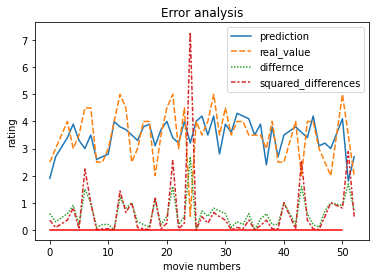

In [84]:
plt.title('Error analysis')
plt.xlabel('movie numbers')
plt.ylabel('rating')
sns.lineplot(data = result[:50])
sns.lineplot(x=[0,50], y=[0,0], color='red')
plt.show()


### A different approach to error analysis

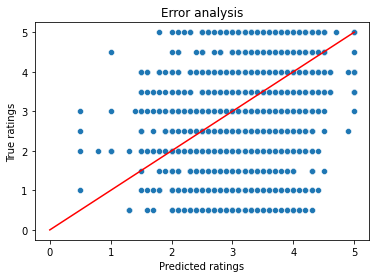

In [85]:
plt.title('Error analysis')
plt.xlabel('Predicted ratings')
plt.ylabel('True ratings')
sns.lineplot(x=[0,5], y=[0,5], color='red')
sns.scatterplot(x=prediction, y= real_value)
plt.show()

### Mean squared error prediction (MSE): doing it manually

In [86]:
sum(result.squared_differences)/result.squared_differences.size 

0.9459399123722086

# Write a function to get all error matrics at the same time


        MSE : 0.9459399123722093
        RMSE : 0.9725944233709184
        MAE: 0.7587523471729606
        


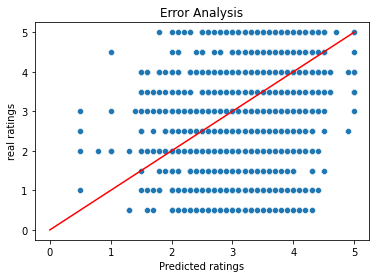

In [87]:
def prediction_analyst(real_value, prediction):
    print(
        f"""
        MSE : {mean_squared_error(real_value, prediction)}
        RMSE : {mean_squared_error(real_value, prediction)**0.5}
        MAE: {mean_absolute_error(result.real_value, result.prediction)}
        """
    )
    plt.title('Error Analysis')
    plt.xlabel('Predicted ratings')
    plt.ylabel('real ratings')
    sns.lineplot(x = [0, 5], y= [0,5], color = 'red')
    sns.scatterplot( x = prediction, y= real_value)
    plt.show()
prediction_analyst(result.real_value, result.prediction)

<AxesSubplot:>

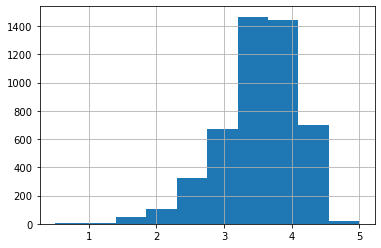

In [88]:
result.prediction.hist()

<AxesSubplot:>

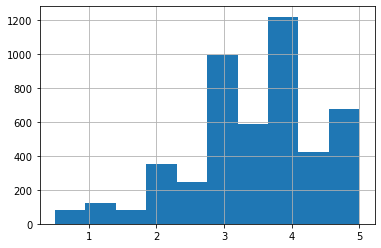

In [269]:
result.real_value.hist()